In [1]:
!pip install pandas numpy scikit-learn matplotlib joblib

  Using cached pandas-2.3.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached numpy-2.3.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (62 kB)
  Using cached scikit_learn-1.7.2-cp311-cp311-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached matplotlib-3.10.7-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached scipy-1.16.2-cp311-cp311-macosx_12_0_arm64.whl.metadata (62 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached contourpy-1.3.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp311-cp311-macosx_10_9_universal2.whl.metadata (112 kB)
  Using cached kiwisolver-1.4.9-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using ca

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib


## Helper functions
- `read_fasta`: read sequences from FASTA into a dictionary of {name: sequence} so that we can merge it with labels
- `normalize_seq`: Cleans each sequence (uppercase, replaces U→T, removes invalid characters) to make all data consistent. 
- `gc_content`: Calculates the GC fraction — the ratio of G and C bases to total bases, a useful biological feature.  
- `kmerize`: kmerize(seq, k=4) → Breaks the sequence into overlapping 4-letter chunks (k-mers) so the model can learn small sequence patterns.


In [8]:
def read_fasta(path):
    """Return dict {name: sequence} from a FASTA file."""
    seqs = {}
    with open(path) as f:
        name, buf = None, []
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if name:
                    seqs[name] = "".join(buf)
                name = line[1:].split()[0]
                buf = []
            else:
                buf.append(line)
        if name:
            seqs[name] = "".join(buf)
    return seqs

def normalize_seq(s: str) -> str:
    s = s.upper().replace('U', 'T')
    return re.sub(r'[^ACGT]', '', s)

def gc_content(s: str) -> float:
    return (s.count('G') + s.count('C')) / len(s) if s else 0.0

def kmerize(seq: str, k: int = 4) -> str:
    """Return 'AAAA AAAC ...' style string of k-mers for vectorizer."""
    if not seq or len(seq) < k: 
        return ""
    return " ".join(seq[i:i+k] for i in range(len(seq)-k+1))


1. The code merges RNA sequence data with their corresponding class labels.
2. It first reads the FASTA file using read_fasta() to create a dictionary of sequence names and nucleotide strings.
3. This dictionary is converted into a DataFrame (df_seq) containing cleaned sequences using the normalize_seq() function.
4. The label file (training_class.csv) is loaded separately into another DataFrame (df_lbl).
5. Both DataFrames are merged on the name column using a left join, ensuring that all labeled entries are retained even if some sequences are missing.
6. After merging, the code prints the total number of rows, label counts, and displays the first few entries to confirm the merge.
7. The resulting DataFrame (df) becomes the complete dataset ready for exploration and model training.

In [20]:
FASTA_PATH = "data/training.fa"   
LABELS_PATH = "data/training_class.csv"

seq_dict = read_fasta(FASTA_PATH)
df_seq = pd.DataFrame({"name": list(seq_dict.keys()),
                       "sequence": [normalize_seq(s) for s in seq_dict.values()]})
df_lbl = pd.read_csv(LABELS_PATH)

df = df_lbl.merge(df_seq, on="name", how="left")
print(f"✅ Loaded {len(df)} labeled sequences")
print("Label counts:\n", df["class"].value_counts(), "\n")
df.head()


✅ Loaded 22867 labeled sequences
Label counts:
 class
0    14035
1     8832
Name: count, dtype: int64 



,name,class,sequence
0,ENSDART00000138379,1,TCAAAGGAAAATAATATGTCAGTGTGATTTTTACTCGATTAATACG...
1,ENSDART00000075994,1,ATGTCTCTTTTTGAAATAAAAGACCTGTTGAGAAGGAAGCTATGGC...
2,ENSDART00000153938,1,AGACCAGTGGTTTAGCAGCAACAGCTTTCGAGCGACGGAAACATGC...
3,ENSDART00000152541,1,CGATGGGTCCGACCAAGATGGCGCTCTAACAACAAGCAGATCGATG...
4,ENSDART00000139170,1,TCGGACTTCTCATATGTTTTCGACTCTTCGAAGAACTAAACATTAA...


Identifying the missing sequences 
1. The code checks whether any rows in the merged dataset are missing RNA sequences.
2. It creates a new DataFrame named missing that filters out rows where the “sequence” column is either empty ("") or contains a null value (NaN).
3. This helps identify label entries that did not find a matching sequence in the FASTA file during merging.
4. It prints the number of missing rows compared to the total dataset size, allowing you to gauge how many mismatches exist.
5. Finally, missing.head() displays the first few examples so you can inspect which sequence names or labels are missing corresponding sequence data.

In [22]:
# Check for missing sequences after the merge
missing = df[df["sequence"].isna() | (df["sequence"] == "")]
print(f"⚠️ Missing: {len(missing)} out of {len(df)} total rows")

# Show a few examples
missing.head()


⚠️ Missing: 8581 out of 22867 total rows


,name,class,sequence
364,hg19_ct_UserTrack_3545_TCONS_00006125 range=ch...,1,NaN
365,hg19_ct_UserTrack_3545_TCONS_00012486 range=ch...,1,NaN
366,hg19_ct_UserTrack_3545_TCONS_00012852 range=ch...,1,NaN
367,hg19_ct_UserTrack_3545_TCONS_00014223 range=ch...,1,NaN
368,hg19_ct_UserTrack_3545_TCONS_00012861 range=ch...,1,NaN


Cleaning Missing Sequences
1. This code removes all rows that do not contain valid RNA sequences.
2. The first line drops rows where the “sequence” column is missing (NaN).
3. The second line removes rows where the sequence is blank ("").
4. These steps ensure that only entries with actual nucleotide sequences remain in the DataFrame.
5. After cleaning, the code prints the total number of valid rows left.
6. It then displays the first few entries using df.head() to confirm that the dataset now contains only complete and usable data for further analysis.

In [25]:
# Drop missing or blank sequences directly from df
df = df.dropna(subset=["sequence"])
df = df[df["sequence"] != ""]

print(f"✅ Cleaned: {len(df)} valid rows remaining.")
df.head()


✅ Cleaned: 14286 valid rows remaining.


,name,class,sequence,length
0,ENSDART00000138379,1,TCAAAGGAAAATAATATGTCAGTGTGATTTTTACTCGATTAATACG...,2449.0
1,ENSDART00000075994,1,ATGTCTCTTTTTGAAATAAAAGACCTGTTGAGAAGGAAGCTATGGC...,758.0
2,ENSDART00000153938,1,AGACCAGTGGTTTAGCAGCAACAGCTTTCGAGCGACGGAAACATGC...,2122.0
3,ENSDART00000152541,1,CGATGGGTCCGACCAAGATGGCGCTCTAACAACAAGCAGATCGATG...,3957.0
4,ENSDART00000139170,1,TCGGACTTCTCATATGTTTTCGACTCTTCGAAGAACTAAACATTAA...,1002.0


Exploratory Data Analysis (EDA) on the Cleaned Dataset
1. This code performs basic exploratory data analysis (EDA) to understand the dataset’s structure and composition.
2. A new column called “length” is created to store the number of nucleotides in each sequence using str.len().
3. Another column, “gc”, is added to calculate the GC content of each sequence using the gc_content function.
4. The code prints label counts to show how many samples belong to each class (0 or 1).
5. It also prints descriptive statistics of sequence lengths, including mean, minimum, and maximum values.
6. Two histograms are plotted — one for sequence length distribution and another for GC content distribution.
7. These visualizations help identify typical sequence lengths and GC proportions, providing insights into data variation before model training.


Label counts:
 class
0    9224
1    5062
Name: count, dtype: int64 

Length stats:
 count    14286.000000
mean      1571.979490
std       2529.910692
min         21.000000
25%        456.000000
50%        652.000000
75%       1433.000000
max      25590.000000
Name: length, dtype: float64 



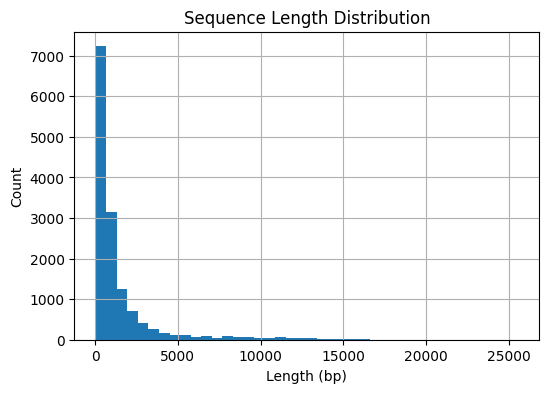

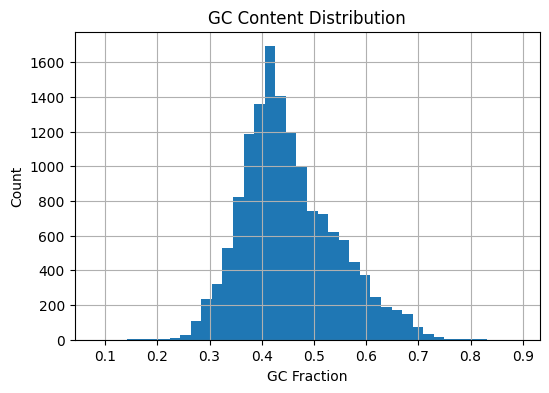

In [26]:
df["length"] = df["sequence"].str.len()
df["gc"] = df["sequence"].map(gc_content)

print("Label counts:\n", df["class"].value_counts(), "\n")
print("Length stats:\n", df["length"].describe(), "\n")

# Length histogram
plt.figure(figsize=(6,4))
df["length"].hist(bins=40)
plt.title("Sequence Length Distribution")
plt.xlabel("Length (bp)")
plt.ylabel("Count")
plt.show()

# GC histogram
plt.figure(figsize=(6,4))
df["gc"].hist(bins=40)
plt.title("GC Content Distribution")
plt.xlabel("GC Fraction")
plt.ylabel("Count")
plt.show()


Model Training and Evaluation Process
1. The code begins by converting each RNA sequence into overlapping 4-letter fragments, known as 4-mers, using the kmerize function.
2. These 4-mers are then transformed into a numeric matrix with CountVectorizer, which counts the frequency of each possible 4-mer pattern.
3. To make sequences of different lengths comparable, the resulting matrix is normalized, ensuring each sequence contributes equally to the model.
4. The dataset is split into training (80%) and validation (20%) sets while preserving the class balance using stratification.
5. A logistic regression model is trained with class_weight='balanced' to handle unequal class distributions.
6. After training, the model predicts both class labels (y_pred) and probabilities (y_prob) on the validation data.
7. Finally, the code prints key evaluation metrics—precision, recall, F1-score, confusion matrix, and ROC AUC—summarizing how well the model can distinguish between mRNA and non-mRNA sequences.

In [19]:
# Convert sequences to 4-mer strings
X_text = df["sequence"].map(lambda s: kmerize(s, k=4))
y = df["class"].astype(int).values

# Convert 4-mers to numeric matrix
vec = CountVectorizer(analyzer="word")
X = vec.fit_transform(X_text)

# Normalize so that all sequences contribute equally
X = normalize(X, norm="l1")

# Split into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train logistic regression
model = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)[:, 1]

print("=== Validation Performance ===")
print(classification_report(y_val, y_pred, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("ROC AUC:", round(roc_auc_score(y_val, y_prob), 4))


=== Validation Performance ===
              precision    recall  f1-score   support

           0      0.827     0.767     0.796      1845
           1      0.625     0.707     0.664      1013

    accuracy                          0.746      2858
   macro avg      0.726     0.737     0.730      2858
weighted avg      0.755     0.746     0.749      2858

Confusion Matrix:
 [[1416  429]
 [ 297  716]]
ROC AUC: 0.8045


Saving the Model and Vectorizer
1. This step saves the trained logistic regression model and its fitted vectorizer for future use without retraining.
2. The model (logreg_k4.joblib) represents the trained Logistic Regression classifier that has learned the relationship between 4-mer patterns and mRNA labels.
3. The vectorizer (kmer_vec_k4.joblib) is the tool that converts RNA sequences into their numeric 4-mer representations, exactly as done during training.
4. Saving both ensures that the same preprocessing and model behavior can be reproduced when making new predictions.
5. This guarantees consistency and reproducibility across future experiments or applications.

In [13]:
joblib.dump(clf, "models/logreg_k4.joblib")
joblib.dump(vec, "models/kmer_vec_k4.joblib")
print("✅ Saved model and vectorizer to 'models/'")

✅ Saved model and vectorizer to 'models/'


Step 8 – Making Predictions on the Test Dataset
1. The code loads the unseen test dataset from test.csv to generate predictions using the trained model.
2. Each sequence is cleaned with the normalize_seq function to ensure consistent formatting.
3. The cleaned sequences are converted into 4-mer patterns using the kmerize function.
4. The saved vectorizer (kmer_vec_k4.joblib) is used to transform these 4-mers into the same numeric format as the training data, followed by normalization.
5. The trained model (logreg_k4.joblib) then predicts the probability of each sequence being mRNA (prob_mrna).
6. A final class label (pred_class) is assigned based on whether the probability is greater than or equal to 0.5.
7. The predictions are saved to outputs/test_predictions.csv, and the first few rows are displayed to confirm successful prediction generation.

In [14]:
TEST_PATH = "data/test.csv"
test = pd.read_csv(TEST_PATH)

# Clean + 4-mer strings
test["sequence"] = test["sequence"].astype(str).map(normalize_seq)
test_text = test["sequence"].map(lambda s: kmerize(s, k=4))

# Vectorize with the SAME vectorizer
X_test = vec.transform(test_text)
X_test = normalize(X_test, norm="l1")

# Predict
test["prob_mrna"] = clf.predict_proba(X_test)[:, 1]
test["pred_class"] = (test["prob_mrna"] >= 0.5).astype(int)

# Save
out_path = "outputs/test_predictions.csv"
test.to_csv(out_path, index=False)
print("✅ Predictions saved to:", out_path)

test.head()


✅ Predictions saved to: outputs/test_predictions.csv


,name,sequence,class,prob_mrna,pred_class
0,TCONS_00059596,CTAATCCCCCCTCCTCCCGCTCCCGCACCAAAGAGTTGCGCCGCCT...,1,0.517011,1
1,TCONS_00059678,CTATTCGGCGCAGTTGCTATACGTACCCCAGCCTCGTACACAACGC...,1,0.503730,1
2,TCONS_00059721,CCGCCGCCCCGCCCCGCCCATCTTGTCAGATCCTTCTTCATAGTTA...,1,0.498770,0
3,TCONS_00059758,CTCGTCGATCCGCCGGGTCTTTCCTACTTCACTGTCCATTGCCCGG...,1,0.510455,1
4,TCONS_00060154,ATGGCGGCTCGCCGTTTCTCCGCCGCCACGCCCTCCTCTCCCCTCC...,1,0.484455,0
